In [83]:
import numpy as np

In [5]:
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors

In [44]:
# 本地向量集

In [45]:
from pyspark.mllib.linalg import Vectors,Vector

In [63]:
vd = Vectors.dense(2, 0, 3)

In [64]:
vd

DenseVector([2.0, 0.0, 3.0])

In [65]:
vd = Vectors.sparse(4, [1, 3], [2, 3])

In [66]:
vd

SparseVector(4, {1: 2.0, 3: 3.0})

In [58]:
# 向量标签

In [60]:
from pyspark.mllib.regression import LabeledPoint

In [74]:
vd = Vectors.dense(2, 0, 3)
lp = LabeledPoint(1, vd)

In [75]:
lp

LabeledPoint(1.0, [2.0,0.0,3.0])

In [76]:
lp.features, lp.label

(DenseVector([2.0, 0.0, 3.0]), 1.0)

In [77]:
vd = Vectors.sparse(4, [1, 3], [2, 3])
lp = LabeledPoint(0, vd)

In [78]:
lp

LabeledPoint(0.0, (4,[1,3],[2.0,3.0]))

In [79]:
# 本地矩阵

In [80]:
from pyspark.mllib.linalg import  Matrices

In [88]:
data = [1,2,3,4,5,6]
mx = Matrices.dense(2, 3, data)

In [89]:
mx

DenseMatrix(2, 3, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0], False)

In [93]:
mx_arr = mx.toArray()
print(mx_arr, type(mx_arr))

[[1. 3. 5.]
 [2. 4. 6.]] <class 'numpy.ndarray'>


In [111]:
rdd = sc.parallelize([Vectors.dense([1,2,4]),
                      Vectors.dense([2,2,2]),
                      Vectors.dense([2,2,3]),
                     ])

In [112]:
stat = Statistics.colStats(rdd)

In [113]:
stat.max()

array([2., 2., 4.])

In [114]:
stat.min()

array([1., 2., 2.])

In [115]:
stat.mean()

array([1.66666667, 2.        , 3.        ])

In [116]:
stat.variance()

array([0.33333333, 0.        , 1.        ])

In [126]:
# corr

In [122]:
x = sc.parallelize([1.0, 0.0, -2.0])
y = sc.parallelize([4.0, 5.0, 3.0])

In [123]:
Statistics.corr(x, y, "spearman")

0.5

In [127]:
# 卡方

In [133]:
vd = Vectors.dense([1,2,3,4,5,6])

In [136]:
cd_chi = Statistics.chiSqTest(vd)

In [138]:
print(cd_chi)

Chi squared test summary:
method: pearson
degrees of freedom = 5 
statistic = 5.000000000000001 
pValue = 0.4158801869955079 
No presumption against null hypothesis: observed follows the same distribution as expected..


In [139]:
mx = Matrices.dense(2, 3, [1,2,3,4,5,6])
cd_chi = Statistics.chiSqTest(mx)
print(cd_chi)

Chi squared test summary:
method: pearson
degrees of freedom = 2 
statistic = 0.14141414141414146 
pValue = 0.931734784568187 
No presumption against null hypothesis: the occurrence of the outcomes is statistically independent..


In [1]:
pwd = !pwd
data_path = "file://" + list(pwd)[0] + '/data/ai/'
print(data_path)

file:///root/pyspark-book/data/ai/


In [140]:
sc.stop()

## Linear Regression

In [141]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName('line_reg')\
    .getOrCreate()

In [142]:
spark

### 读取数据集

In [4]:
df = spark.read.csv(data_path + 'linear_regression.csv', header=True, inferSchema=True)

In [5]:
df.show(3)

+-----+-----+-----+-----+-----+------+
|var_1|var_2|var_3|var_4|var_5|output|
+-----+-----+-----+-----+-----+------+
|  734|  688|   81|0.328|0.259| 0.418|
|  700|  600|   94| 0.32|0.247| 0.389|
|  712|  705|   93|0.311|0.247| 0.417|
+-----+-----+-----+-----+-----+------+
only showing top 3 rows



In [6]:
df.head(3)

[Row(var_1=734, var_2=688, var_3=81, var_4=0.328, var_5=0.259, output=0.418),
 Row(var_1=700, var_2=600, var_3=94, var_4=0.32, var_5=0.247, output=0.389),
 Row(var_1=712, var_2=705, var_3=93, var_4=0.311, var_5=0.247, output=0.417)]

In [7]:
df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)



In [8]:
df.count()

1232

In [9]:
import pyspark.sql.functions as F

In [10]:
df.select(F.corr('var_1','output')).show()

+-------------------+
|corr(var_1, output)|
+-------------------+
| 0.9187399607627283|
+-------------------+



In [11]:
df.columns

['var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'output']

### 数据预处理

In [12]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [13]:
vec_assmebler = VectorAssembler(
    inputCols=['var_1', 'var_2', 'var_3', 'var_4', 'var_5'],
    outputCol='features'
)

In [14]:
features_df = vec_assmebler.transform(df)

In [15]:
features_df.show(3, False)

+-----+-----+-----+-----+-----+------+------------------------------+
|var_1|var_2|var_3|var_4|var_5|output|features                      |
+-----+-----+-----+-----+-----+------+------------------------------+
|734  |688  |81   |0.328|0.259|0.418 |[734.0,688.0,81.0,0.328,0.259]|
|700  |600  |94   |0.32 |0.247|0.389 |[700.0,600.0,94.0,0.32,0.247] |
|712  |705  |93   |0.311|0.247|0.417 |[712.0,705.0,93.0,0.311,0.247]|
+-----+-----+-----+-----+-----+------+------------------------------+
only showing top 3 rows



In [16]:
features_df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)
 |-- features: vector (nullable = true)



In [17]:
model_df = features_df.select('features','output')

In [18]:
model_df.show(5, False)

+------------------------------+------+
|features                      |output|
+------------------------------+------+
|[734.0,688.0,81.0,0.328,0.259]|0.418 |
|[700.0,600.0,94.0,0.32,0.247] |0.389 |
|[712.0,705.0,93.0,0.311,0.247]|0.417 |
|[734.0,806.0,69.0,0.315,0.26] |0.415 |
|[613.0,759.0,61.0,0.302,0.24] |0.378 |
+------------------------------+------+
only showing top 5 rows



In [19]:
model_df.count()

1232

### Split Data - Train & Test

In [20]:
train_df, test_df = model_df.randomSplit([0.7,0.3])

In [21]:
print((train_df.count(), len(train_df.columns)))

(863, 2)


In [22]:
print((test_df.count(), len(test_df.columns)))

(369, 2)


In [23]:
train_df.describe().show()

+-------+-------------------+
|summary|             output|
+-------+-------------------+
|  count|                863|
|   mean|0.39804866743916506|
| stddev|0.03266542685059044|
|    min|              0.301|
|    max|              0.485|
+-------+-------------------+



### 创建 Linear Regression Model  & 训练

In [24]:
from pyspark.ml.regression import LinearRegression

In [25]:
model = LinearRegression(labelCol='output')

In [26]:
line_model = model.fit(train_df)

In [28]:
print("Line intercept:", line_model.intercept)
print("Line coefficients:\n", line_model.coefficients)

Line intercept: 0.19629213927216993
Line coefficients:
 [0.00034834707065082687,4.529439013419945e-05,0.0001405600894934997,-0.6404804066457538,0.45320821437302533]


In [30]:
training_predictions = line_model.evaluate(train_df)

In [31]:
training_predictions.meanSquaredError

0.00014646189455796058

In [32]:
training_predictions.r2

0.8625795069968039

In [33]:
predict = line_model.evaluate(test_df)

In [34]:
predict

In [35]:
predict.residuals.show(10)

+--------------------+
|           residuals|
+--------------------+
|0.009147759629577423|
|-0.00227956950959...|
|-0.01269354735256...|
|-0.00554102271364...|
|-0.00102140748644...|
|0.007722186299581879|
|-0.01176710073555...|
|2.160571382503473...|
|-0.01282486860941...|
|-0.00236545311215...|
+--------------------+
only showing top 10 rows



In [36]:
print("R^2:", predict.r2)

R^2: 0.8820258243690249


In [37]:
print("RMSE:", predict.rootMeanSquaredError)

RMSE: 0.011875565934291885


In [38]:
print("MSE:", predict.meanSquaredError)

MSE: 0.00014102906625971387


In [39]:
spark.stop()

## Logistic Regression 

In [40]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName('log_reg')\
    .getOrCreate()

In [41]:
spark

### 读取数据集

In [42]:
df = spark.read.csv(data_path + 'logit_regression.csv', header=True, inferSchema=True)

In [43]:
df.show(3)

+-------+---+--------------+--------+----------------+------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+-------+---+--------------+--------+----------------+------+
|  India| 41|             1|   Yahoo|              21|     1|
| Brazil| 28|             1|   Yahoo|               5|     0|
| Brazil| 40|             0|  Google|               3|     0|
+-------+---+--------------+--------+----------------+------+
only showing top 3 rows



In [44]:
df.head(3)

[Row(Country='India', Age=41, Repeat_Visitor=1, Platform='Yahoo', Web_pages_viewed=21, Status=1),
 Row(Country='Brazil', Age=28, Repeat_Visitor=1, Platform='Yahoo', Web_pages_viewed=5, Status=0),
 Row(Country='Brazil', Age=40, Repeat_Visitor=0, Platform='Google', Web_pages_viewed=3, Status=0)]

In [45]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



In [46]:
df.count()

20000

In [47]:
import pyspark.sql.functions as F

In [48]:
df.groupBy('Country').count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



In [49]:
df.groupBy('Platform').count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



In [50]:
df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



In [51]:
df.groupBy('Country').mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



In [52]:
df.groupBy('Platform').mean().show()

+--------+------------------+-------------------+---------------------+------------------+
|Platform|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|       avg(Status)|
+--------+------------------+-------------------+---------------------+------------------+
|   Yahoo|28.569226087838523| 0.5094837204584644|    9.599655137437875|0.5071508266558474|
|    Bing| 28.68394495412844| 0.4720183486238532|    9.114908256880733|0.4559633027522936|
|  Google|28.380038055699707| 0.5149628092025601|    9.804878048780488|0.5210171250648676|
+--------+------------------+-------------------+---------------------+------------------+



In [53]:
df.groupBy('Status').mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



### 数据预处理

In [54]:
from pyspark.ml.feature import StringIndexer

In [55]:
platform_indexer = StringIndexer(
    inputCol="Platform", 
    outputCol="Platform_Index"
).fit(df)

In [56]:
df = platform_indexer.transform(df)

In [57]:
df.show(5)

+---------+---+--------------+--------+----------------+------+--------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Index|
+---------+---+--------------+--------+----------------+------+--------------+
|    India| 41|             1|   Yahoo|              21|     1|           0.0|
|   Brazil| 28|             1|   Yahoo|               5|     0|           0.0|
|   Brazil| 40|             0|  Google|               3|     0|           1.0|
|Indonesia| 31|             1|    Bing|              15|     1|           2.0|
| Malaysia| 32|             0|  Google|              15|     1|           1.0|
+---------+---+--------------+--------+----------------+------+--------------+
only showing top 5 rows



In [58]:
from pyspark.ml.feature import OneHotEncoder

In [59]:
platform_encoder = OneHotEncoder(
    inputCol="Platform_Index", 
    outputCol="Platform_Vector"
)

df = platform_encoder.transform(df)

In [60]:
df.show(5)

+---------+---+--------------+--------+----------------+------+--------------+---------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Index|Platform_Vector|
+---------+---+--------------+--------+----------------+------+--------------+---------------+
|    India| 41|             1|   Yahoo|              21|     1|           0.0|  (2,[0],[1.0])|
|   Brazil| 28|             1|   Yahoo|               5|     0|           0.0|  (2,[0],[1.0])|
|   Brazil| 40|             0|  Google|               3|     0|           1.0|  (2,[1],[1.0])|
|Indonesia| 31|             1|    Bing|              15|     1|           2.0|      (2,[],[])|
| Malaysia| 32|             0|  Google|              15|     1|           1.0|  (2,[1],[1.0])|
+---------+---+--------------+--------+----------------+------+--------------+---------------+
only showing top 5 rows



In [61]:
df.groupBy('Platform')\
    .count()\
    .orderBy('count',ascending=False)\
    .show(5)

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|  Google| 5781|
|    Bing| 4360|
+--------+-----+



In [62]:
df.groupBy('Platform','Platform_Index','Platform_Vector')\
    .count()\
    .orderBy('count',ascending=False)\
    .show(5)

+--------+--------------+---------------+-----+
|Platform|Platform_Index|Platform_Vector|count|
+--------+--------------+---------------+-----+
|   Yahoo|           0.0|  (2,[0],[1.0])| 9859|
|  Google|           1.0|  (2,[1],[1.0])| 5781|
|    Bing|           2.0|      (2,[],[])| 4360|
+--------+--------------+---------------+-----+



In [63]:
country_indexer = StringIndexer(
    inputCol="Country", 
    outputCol="Country_Index"
).fit(df)

In [64]:
df = country_indexer.transform(df)

In [65]:
df.show(5)

+---------+---+--------------+--------+----------------+------+--------------+---------------+-------------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Index|Platform_Vector|Country_Index|
+---------+---+--------------+--------+----------------+------+--------------+---------------+-------------+
|    India| 41|             1|   Yahoo|              21|     1|           0.0|  (2,[0],[1.0])|          1.0|
|   Brazil| 28|             1|   Yahoo|               5|     0|           0.0|  (2,[0],[1.0])|          2.0|
|   Brazil| 40|             0|  Google|               3|     0|           1.0|  (2,[1],[1.0])|          2.0|
|Indonesia| 31|             1|    Bing|              15|     1|           2.0|      (2,[],[])|          0.0|
| Malaysia| 32|             0|  Google|              15|     1|           1.0|  (2,[1],[1.0])|          3.0|
+---------+---+--------------+--------+----------------+------+--------------+---------------+-------------+
only showing top 5 

In [66]:
country_encoder = OneHotEncoder(
    inputCol="Country_Index", 
    outputCol="Country_Vector"
)

df = country_encoder.transform(df)

In [67]:
df.select(['Country','Country_Index','Country_Vector']).show(5)

+---------+-------------+--------------+
|  Country|Country_Index|Country_Vector|
+---------+-------------+--------------+
|    India|          1.0| (3,[1],[1.0])|
|   Brazil|          2.0| (3,[2],[1.0])|
|   Brazil|          2.0| (3,[2],[1.0])|
|Indonesia|          0.0| (3,[0],[1.0])|
| Malaysia|          3.0|     (3,[],[])|
+---------+-------------+--------------+
only showing top 5 rows



In [68]:
df.groupBy('Country','Country_Index','Country_Vector')\
    .count()\
    .orderBy('count',ascending=False)\
    .show(5)

+---------+-------------+--------------+-----+
|  Country|Country_Index|Country_Vector|count|
+---------+-------------+--------------+-----+
|Indonesia|          0.0| (3,[0],[1.0])|12178|
|    India|          1.0| (3,[1],[1.0])| 4018|
|   Brazil|          2.0| (3,[2],[1.0])| 2586|
| Malaysia|          3.0|     (3,[],[])| 1218|
+---------+-------------+--------------+-----+



In [69]:
from pyspark.ml.feature import VectorAssembler

In [70]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Index: double (nullable = false)
 |-- Platform_Vector: vector (nullable = true)
 |-- Country_Index: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)



In [71]:
assembler = VectorAssembler(
    inputCols=['Platform_Vector','Country_Vector','Age', 'Repeat_Visitor','Web_pages_viewed'], 
    outputCol='features'
)

df = assembler.transform(df)

In [72]:
df.select(
    'Platform_Vector',
    'Country_Vector',
    'Age', 
    'Repeat_Visitor',
    'Web_pages_viewed', 
    'features', 
    'status').show(5, False)

+---------------+--------------+---+--------------+----------------+-----------------------------------+------+
|Platform_Vector|Country_Vector|Age|Repeat_Visitor|Web_pages_viewed|features                           |status|
+---------------+--------------+---+--------------+----------------+-----------------------------------+------+
|(2,[0],[1.0])  |(3,[1],[1.0]) |41 |1             |21              |[1.0,0.0,0.0,1.0,0.0,41.0,1.0,21.0]|1     |
|(2,[0],[1.0])  |(3,[2],[1.0]) |28 |1             |5               |[1.0,0.0,0.0,0.0,1.0,28.0,1.0,5.0] |0     |
|(2,[1],[1.0])  |(3,[2],[1.0]) |40 |0             |3               |(8,[1,4,5,7],[1.0,1.0,40.0,3.0])   |0     |
|(2,[],[])      |(3,[0],[1.0]) |31 |1             |15              |(8,[2,5,6,7],[1.0,31.0,1.0,15.0])  |1     |
|(2,[1],[1.0])  |(3,[],[])     |32 |0             |15              |(8,[1,5,7],[1.0,32.0,15.0])        |1     |
+---------------+--------------+---+--------------+----------------+-----------------------------------+

In [73]:
model_df = df.select(['features','Status'])

### Split Data - Train & Test

In [74]:
train_df, test_df = model_df.randomSplit([0.7,0.3])

In [75]:
print((train_df.count(), len(train_df.columns)))

(13928, 2)


In [76]:
print((test_df.count(), len(test_df.columns)))

(6072, 2)


In [77]:
test_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 2982|
|     0| 3090|
+------+-----+



In [78]:
train_df.describe().show()

+-------+------------------+
|summary|            Status|
+-------+------------------+
|  count|             13928|
|   mean| 0.503877082136703|
| stddev|0.5000029178894279|
|    min|                 0|
|    max|                 1|
+-------+------------------+



### 创建 Logit Regression Model  & 训练

In [79]:
from pyspark.ml.classification import LogisticRegression

In [80]:
model = LogisticRegression(labelCol='Status')

In [81]:
lr_model = model.fit(train_df)

In [82]:
train_results = lr_model.evaluate(train_df).predictions

In [83]:
train_results\
    .filter('prediction==1')\
    .select(['Status','prediction','probability'])\
    .show(5 ,False)

+------+----------+----------------------------------------+
|Status|prediction|probability                             |
+------+----------+----------------------------------------+
|0     |1.0       |[0.4887399536716742,0.5112600463283258] |
|0     |1.0       |[0.4887399536716742,0.5112600463283258] |
|1     |1.0       |[0.31054999293854174,0.6894500070614583]|
|1     |1.0       |[0.31054999293854174,0.6894500070614583]|
|1     |1.0       |[0.31054999293854174,0.6894500070614583]|
+------+----------+----------------------------------------+
only showing top 5 rows



In [84]:
train_results\
    .filter('prediction==0')\
    .select(['Status','prediction','probability'])\
    .show(5 ,False)

+------+----------+-----------------------------------------+
|Status|prediction|probability                              |
+------+----------+-----------------------------------------+
|0     |0.0       |[0.9974648500487034,0.002535149951296541]|
|0     |0.0       |[0.9974648500487034,0.002535149951296541]|
|0     |0.0       |[0.9974648500487034,0.002535149951296541]|
|0     |0.0       |[0.9974648500487034,0.002535149951296541]|
|0     |0.0       |[0.9974648500487034,0.002535149951296541]|
+------+----------+-----------------------------------------+
only showing top 5 rows



In [85]:
correct_preds = train_results\
    .filter(train_results['Status']==1)\
    .filter(train_results['prediction']==1)\
    .count()

all_counts = train_df.filter('Status==1').count()

print(correct_preds, all_counts)

6586 7018


In [86]:
accuracy = float(correct_preds)/(all_counts)
print('accuracy:', accuracy)

accuracy: 0.9384440011399259


In [87]:
predict = lr_model.evaluate(test_df).predictions

In [88]:
predict.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [89]:
predict.select(['Status','prediction']).show(10, False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|1     |0.0       |
+------+----------+
only showing top 10 rows



In [90]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [91]:
#confusion matrix

In [92]:
true_postives = predict[(predict.Status == 1) & (predict.prediction == 1)].count()
true_negatives = predict[(predict.Status == 0) & (predict.prediction == 0)].count()
false_positives = predict[(predict.Status == 0) & (predict.prediction == 1)].count()
false_negatives = predict[(predict.Status == 1) & (predict.prediction == 0)].count()

In [93]:
#准确率
accuracy=float((true_postives+true_negatives) /(predict.count()))
print("accuracy:",accuracy)
 
#召回率
recall = float(true_postives)/(true_postives + false_negatives)
print("recall:",recall)
 
#精度
precision = float(true_postives) / (true_postives + false_positives)
print("precision:",precision)

accuracy: 0.9380764163372859
recall: 0.937625754527163
precision: 0.9363697253851306


In [94]:
spark.stop()

## K-Means聚类

In [95]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName('k_means')\
    .getOrCreate()

In [96]:
spark

### 读取数据集

In [97]:
df = spark.read.csv(data_path + 'clustering_data.csv', header=True, inferSchema=True)

In [98]:
df.show(3)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 3 rows



In [99]:
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [100]:
df.count()

150

In [101]:
df.select('species').distinct().count()

3

In [102]:
df.groupBy('species').count().orderBy('count',ascending=False).show(10,False)

+----------+-----+
|species   |count|
+----------+-----+
|versicolor|50   |
|setosa    |50   |
|virginica |50   |
+----------+-----+



### 数据预处理

In [103]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [104]:
vec_assembler = VectorAssembler(
    inputCols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], 
    outputCol='features'
)

model_df = vec_assembler.transform(df)

In [105]:
model_df.show(5)

+------------+-----------+------------+-----------+-------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|
+------------+-----------+------------+-----------+-------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+-----------------+
only showing top 5 rows



### 创建 Cluster Model & 训练

In [106]:
from pyspark.ml.clustering import KMeans

In [107]:
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(model_df)
    intra_distance = model.computeCost(model_df)
    errors.append(intra_distance)
    
    print('--'*30)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))

------------------------------------------------------------
With K=2
Within Set Sum of Squared Errors = 152.36870647734008
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 78.94506582597637
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 57.47147508745658
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 46.53558205128334
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 45.96395128205201
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 37.4860212121211
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 36.35147828282878
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 34.79115066845024


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

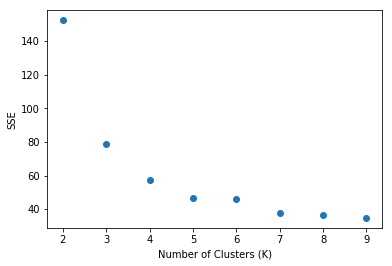

In [109]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

In [110]:
kmeans = KMeans(featuresCol='features',k=3)

In [111]:
model = kmeans.fit(model_df)

In [112]:
model.transform(model_df)\
    .groupBy('prediction')\
    .count()\
    .show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   39|
|         0|   61|
+----------+-----+



In [113]:
predicts = model.transform(model_df)

In [114]:
predicts.show(5)

+------------+-----------+------------+-----------+-------+-----------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species|         features|prediction|
+------------+-----------+------------+-----------+-------+-----------------+----------+
|         5.1|        3.5|         1.4|        0.2| setosa|[5.1,3.5,1.4,0.2]|         1|
|         4.9|        3.0|         1.4|        0.2| setosa|[4.9,3.0,1.4,0.2]|         1|
|         4.7|        3.2|         1.3|        0.2| setosa|[4.7,3.2,1.3,0.2]|         1|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.6,3.1,1.5,0.2]|         1|
|         5.0|        3.6|         1.4|        0.2| setosa|[5.0,3.6,1.4,0.2]|         1|
+------------+-----------+------------+-----------+-------+-----------------+----------+
only showing top 5 rows



In [115]:
predicts\
    .groupBy('species','prediction')\
    .count()\
    .show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   47|
|    setosa|         1|   50|
|versicolor|         2|    3|
+----------+----------+-----+



In [116]:
pandas_df = predicts.toPandas()
pandas_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
61,5.9,3.0,4.2,1.5,versicolor,"[5.9, 3.0, 4.2, 1.5]",0
85,6.0,3.4,4.5,1.6,versicolor,"[6.0, 3.4, 4.5, 1.6]",0
137,6.4,3.1,5.5,1.8,virginica,"[6.4, 3.1, 5.5, 1.8]",2
33,5.5,4.2,1.4,0.2,setosa,"[5.5, 4.2, 1.4, 0.2]",1
129,7.2,3.0,5.8,1.6,virginica,"[7.2, 3.0, 5.8, 1.6]",2


In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

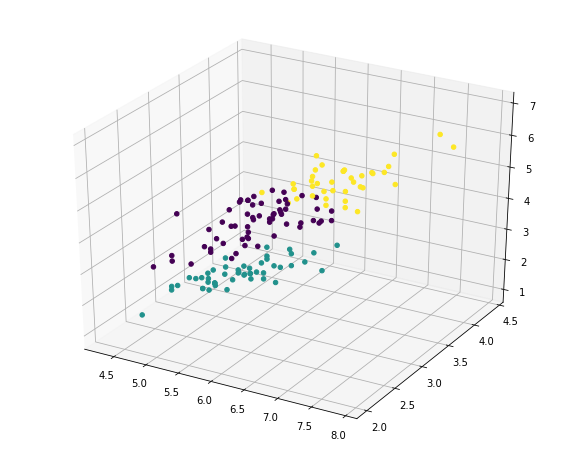

In [118]:
cluster_vis = plt.figure(figsize=(10,8)).gca(projection='3d')
cluster_vis.scatter(
    pandas_df.sepal_length, 
    pandas_df.sepal_width, 
    pandas_df.petal_length, 
    c=pandas_df.prediction,
    depthshade=False)
plt.show()

In [119]:
spark.stop()

## Random_Forests

In [120]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName('Random_Forests')\
    .getOrCreate()

In [121]:
spark

### 读取数据集

In [122]:
df = spark.read.csv(data_path + 'random_forests.csv', header=True, inferSchema=True)

In [123]:
df.show(3)

+-------------+----+-----------+--------+---------+-------+
|rate_marriage| age|yrs_married|children|religious|affairs|
+-------------+----+-----------+--------+---------+-------+
|            5|32.0|        6.0|     1.0|        3|      0|
|            4|22.0|        2.5|     0.0|        2|      0|
|            3|32.0|        9.0|     3.0|        3|      1|
+-------------+----+-----------+--------+---------+-------+
only showing top 3 rows



In [124]:
df.printSchema()

root
 |-- rate_marriage: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- yrs_married: double (nullable = true)
 |-- children: double (nullable = true)
 |-- religious: integer (nullable = true)
 |-- affairs: integer (nullable = true)



In [125]:
df.count()

6366

In [126]:
df.describe().select('summary','rate_marriage','age','yrs_married','children','religious').show(5)

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|     rate_marriage|               age|      yrs_married|          children|         religious|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|              6366|              6366|             6366|              6366|              6366|
|   mean| 4.109644989004084|29.082862079798932| 9.00942507068803|1.3968740182218033|2.4261702796104303|
| stddev|0.9614295945655025| 6.847881883668817|7.280119972766412| 1.433470828560344|0.8783688402641785|
|    min|                 1|              17.5|              0.5|               0.0|                 1|
|    max|                 5|              42.0|             23.0|               5.5|                 4|
+-------+------------------+------------------+-----------------+------------------+------------------+



In [127]:
df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 2053|
|      0| 4313|
+-------+-----+



In [128]:
df.groupBy('rate_marriage').count().show()

+-------------+-----+
|rate_marriage|count|
+-------------+-----+
|            1|   99|
|            3|  993|
|            5| 2684|
|            4| 2242|
|            2|  348|
+-------------+-----+



In [129]:
df.groupBy('rate_marriage','affairs')\
    .count()\
    .orderBy('rate_marriage','affairs','count',ascending=True)\
    .show()

+-------------+-------+-----+
|rate_marriage|affairs|count|
+-------------+-------+-----+
|            1|      0|   25|
|            1|      1|   74|
|            2|      0|  127|
|            2|      1|  221|
|            3|      0|  446|
|            3|      1|  547|
|            4|      0| 1518|
|            4|      1|  724|
|            5|      0| 2197|
|            5|      1|  487|
+-------------+-------+-----+



In [130]:
df.groupBy('children','affairs')\
    .count()\
    .orderBy('children','affairs','count',ascending=True)\
    .show()

+--------+-------+-----+
|children|affairs|count|
+--------+-------+-----+
|     0.0|      0| 1912|
|     0.0|      1|  502|
|     1.0|      0|  747|
|     1.0|      1|  412|
|     2.0|      0|  873|
|     2.0|      1|  608|
|     3.0|      0|  460|
|     3.0|      1|  321|
|     4.0|      0|  197|
|     4.0|      1|  131|
|     5.5|      0|  124|
|     5.5|      1|   79|
+--------+-------+-----+



### 数据预处理

In [131]:
from pyspark.ml.feature import VectorAssembler

In [132]:
vec_assembler = VectorAssembler(
    inputCols=['rate_marriage', 'age', 'yrs_married', 'children', 'religious'], 
    outputCol="features"
)

In [133]:
df = vec_assembler.transform(df)

In [134]:
df.show(5)

+-------------+----+-----------+--------+---------+-------+--------------------+
|rate_marriage| age|yrs_married|children|religious|affairs|            features|
+-------------+----+-----------+--------+---------+-------+--------------------+
|            5|32.0|        6.0|     1.0|        3|      0|[5.0,32.0,6.0,1.0...|
|            4|22.0|        2.5|     0.0|        2|      0|[4.0,22.0,2.5,0.0...|
|            3|32.0|        9.0|     3.0|        3|      1|[3.0,32.0,9.0,3.0...|
|            3|27.0|       13.0|     3.0|        1|      1|[3.0,27.0,13.0,3....|
|            4|22.0|        2.5|     0.0|        1|      1|[4.0,22.0,2.5,0.0...|
+-------------+----+-----------+--------+---------+-------+--------------------+
only showing top 5 rows



In [135]:
model_df = df.select(['features','affairs'])

In [136]:
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- affairs: integer (nullable = true)



### Split Data - Train & Test

In [137]:
train_df, test_df = model_df.randomSplit([0.7, 0.3])

In [138]:
train_df.count(), test_df.count()

(4417, 1949)

In [139]:
train_df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 1446|
|      0| 2971|
+-------+-----+



In [140]:
test_df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1|  607|
|      0| 1342|
+-------+-----+



### 创建 Random Forests Model & 训练

In [141]:
from pyspark.ml.classification import RandomForestClassifier

In [142]:
rf_classifier = RandomForestClassifier(
    labelCol='affairs',
    numTrees=50
)
rf_model = rf_classifier.fit(train_df)

In [143]:
predicts = rf_model.transform(test_df)

In [144]:
predicts.printSchema()

root
 |-- features: vector (nullable = true)
 |-- affairs: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [145]:
predicts.select('affairs','features','rawPrediction','probability','prediction').show(5)

+-------+--------------------+--------------------+--------------------+----------+
|affairs|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|      1|[1.0,22.0,2.5,1.0...|[19.6265267888139...|[0.39253053577627...|       1.0|
|      1|[1.0,22.0,2.5,1.0...|[19.6265267888139...|[0.39253053577627...|       1.0|
|      0|[1.0,22.0,2.5,1.0...|[19.2068509810410...|[0.38413701962082...|       1.0|
|      1|[1.0,27.0,6.0,1.0...|[17.0007472438811...|[0.34001494487762...|       1.0|
|      0|[1.0,27.0,6.0,1.0...|[16.8786238710087...|[0.33757247742017...|       1.0|
+-------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [146]:
predicts.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1546|
|       1.0|  403|
+----------+-----+



In [147]:
rf_model.featureImportances

SparseVector(5, {0: 0.6524, 1: 0.0236, 2: 0.2025, 3: 0.069, 4: 0.0524})

In [148]:
model_df.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'rate_marriage'},
  {'idx': 1, 'name': 'age'},
  {'idx': 2, 'name': 'yrs_married'},
  {'idx': 3, 'name': 'children'},
  {'idx': 4, 'name': 'religious'}]}

In [149]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [150]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='affairs',
    metricName='accuracy')

In [151]:
accuracy = evaluator.evaluate(predicts)

In [152]:
print('The accuracy of RF on test data is ', round(accuracy, 3))

The accuracy of RF on test data is  0.725


In [153]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='affairs',
    metricName='weightedPrecision')

In [154]:
precision = evaluator.evaluate(predicts)

In [155]:
print('The precision rate on test data is ', round(precision, 3))

The precision rate on test data is  0.707


In [156]:
evaluator = BinaryClassificationEvaluator(
    labelCol='affairs')

In [157]:
auc = evaluator.evaluate(predicts)

In [158]:
print('The auc rate on test data is ', round(auc, 3))

The auc rate on test data is  0.742


In [160]:
rf_model.save(data_path + 'RF_model')

In [161]:
%ll ./data/ai/RF_model

总用量 8
drwxr-xr-x. 2 root 4096 2月   5 20:03 data/
drwxr-xr-x. 2 root   84 2月   5 20:03 metadata/
drwxr-xr-x. 2 root 4096 2月   5 20:03 treesMetadata/


In [162]:
from pyspark.ml.classification import RandomForestClassificationModel

In [163]:
rf = RandomForestClassificationModel.load(data_path + 'RF_model')

In [164]:
rf

RandomForestClassificationModel (uid=RandomForestClassifier_5ef2780a4b05) with 50 trees

In [165]:
model_predicts = rf.transform(test_df)

In [166]:
model_predicts.select('affairs','features','rawPrediction','probability','prediction').show(5)

+-------+--------------------+--------------------+--------------------+----------+
|affairs|            features|       rawPrediction|         probability|prediction|
+-------+--------------------+--------------------+--------------------+----------+
|      1|[1.0,22.0,2.5,1.0...|[19.6265267888139...|[0.39253053577627...|       1.0|
|      1|[1.0,22.0,2.5,1.0...|[19.6265267888139...|[0.39253053577627...|       1.0|
|      0|[1.0,22.0,2.5,1.0...|[19.2068509810410...|[0.38413701962082...|       1.0|
|      1|[1.0,27.0,6.0,1.0...|[17.0007472438811...|[0.34001494487762...|       1.0|
|      0|[1.0,27.0,6.0,1.0...|[16.8786238710087...|[0.33757247742017...|       1.0|
+-------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

